In [2]:
# Putting first-pass image reconstructor into a class.
# Execution is in the cell below (pretty far below!)

# Importing tools
from PIL import Image, ImageFilter
import numpy as np
from numpy import random
import math

class reconstructor1:
    def __init__(self):
        print("Starting naive reconstructor.")
    
    def imRead(self,imPathString):
        """
        Reads in .jpg data from given path string.
        """
        print('Loading image from .jpg.')
        
        # flowers and kitty pictures need to be rotated from their current state in the repo.
        if imPathString == 'TestImages/flowers.jpg' or imPathString == 'TestImages/kitty.jpg':
            self.im = Image.open(imPathString).rotate(-90)
        else:
            self.im = Image.open(imPathString)

    def imConvert(self,RL,RU,CL,CU):
        """
        Converts image in self.im into uint8 array data in self.imCropped,
        with crop bounds given by RL,RU (upper, lower row pixels) and
        CL,CU (upper, lower col pixels)
        """
        print('Converting image to uint8 array data.')
        self.pix = np.array(self.im);
        self.pixCropped = self.pix[RL:RU,CL:CU,0:3]

        # optional cropped image conversion for trial printing
        self.imCropped = Image.fromarray(self.pixCropped,'RGB')
        
    def imPartition(self,rowPartitions,colPartitions):
        """
        Partitions original image in self.pixCropped into rowPartitions rows
        and colPartitions columns.
        """
        print('Setting up partitions.')
        # storing values for # total rows, cols (pixels)
        pixelRows = self.pixCropped.shape[0];
        pixelCols = self.pixCropped.shape[1];

        # row, column length of partitions
        self.rowInterval = math.ceil(pixelRows/rowPartitions);
        self.colInterval = math.ceil(pixelCols/colPartitions);

        ### (optional) preparing and printing a preliminary impression of partitioning ###
        self.pixPartitioned1 = np.copy(self.pixCropped)

        # row partitions
        for i in range(1,rowPartitions):
            rowBegin = i*self.rowInterval-4
            rowEnd   = i*self.rowInterval+5
            self.pixPartitioned1[rowBegin:rowEnd,:,:] = 255

        # column partitions
        for j in range(1,colPartitions):
            colBegin = j*self.colInterval-4
            colEnd   = j*self.colInterval+5
            self.pixPartitioned1[:,colBegin:colEnd,:] = 255

        ### setting up an (optional) concept illustration of the fragmentation ###
        self.imPartitioned1 = Image.fromarray(self.pixPartitioned1)
        
        # storing row, column partitions for later
        self.rowPartitions = rowPartitions
        self.colPartitions = colPartitions
        
    def fragAndShuffle(self,offsetMax,overlapPix):
        """
        Fragments and shuffles the loaded image. Max pixel offset is declared
        in offsetMax; overlap (# pixels) of each fragment is declared in overlapPix.
        For now, I'd keep offsetMax significantly smaller than overlapPix, and overlapPix
        significantly smaller than the dimensions (height, width) of image fragments.
        """
        print('Fragmenting, shuffling, and offsetting original image.')
        self.offsetMax = offsetMax
        self.overlapPix = max(overlapPix,3*offsetMax)

        # determining number of total image fragments based on user input
        self.numFragments = self.rowPartitions*self.colPartitions

        # we can shuffle these flattened indices with a random permutation:
        self.shufFragIndices = np.random.permutation(self.numFragments)

        self.xyOffsets = np.random.randint(2*self.offsetMax+1,
                                           size=(self.numFragments,2))-self.offsetMax
        
        # We'll initialize and fill a 4-D (!) array to handle all the frags in the shuffled
        # order given by shufFragIndices.
        self.pixFrags = np.zeros((self.numFragments,self.rowInterval + 2*overlapPix,
                                  self.colInterval + 2*overlapPix,3),dtype='uint8')

        for i in range(0,self.numFragments):
            # block indices for starting fragmentation
            blockRowInd = self.shufFragIndices[i] // self.colPartitions
            blockColInd = self.shufFragIndices[i] % self.colPartitions

            # defining part of original image given over to fragment 'i'
            # (including overlap and x/y offset)
            startRow = blockRowInd*self.rowInterval - self.overlapPix + self.xyOffsets[i,0]
            endRow = startRow + self.rowInterval + 2*self.overlapPix
            
            startCol = blockColInd*self.colInterval - self.overlapPix + self.xyOffsets[i,1]
            endCol = startCol + self.colInterval + 2*self.overlapPix

            # culling interval back in the case of original image overflow/underflow
            if startRow < 0:
                startRow = abs(self.xyOffsets[i,0])
                endRow = self.rowInterval + 2*self.overlapPix + abs(self.xyOffsets[i,0])
            elif endRow > self.pixCropped.shape[0]:
                startRow = (self.pixCropped.shape[0] - self.rowInterval 
                            - 2*self.overlapPix - abs(self.xyOffsets[i,0]))
                endRow = self.pixCropped.shape[0] - abs(self.xyOffsets[i,0])

            if startCol < 0:
                startCol = abs(self.xyOffsets[i,1])
                endCol = self.colInterval + 2*self.overlapPix + abs(self.xyOffsets[i,1])
            elif endCol > self.pixCropped.shape[1]:
                startCol = (self.pixCropped.shape[1] - self.colInterval
                            - 2*self.overlapPix - abs(self.xyOffsets[i,1]))
                endCol = self.pixCropped.shape[1] - abs(self.xyOffsets[i,1])

            # now we fill in pixFrags (preallocated shape) with shuffled and offset data from
            # pixCropped.
            self.pixFrags[i,:,:,:] = self.pixCropped[startRow:endRow,startCol:endCol,:]
            
            ### optional for viewing shuffled image ###
            
            pixShuffled = np.zeros((self.rowInterval*self.rowPartitions,
                                    self.colInterval*self.colPartitions,3),dtype = 'uint8')

            for i in range(0,self.numFragments):
                blockRowInd = i // self.colPartitions
                blockColInd = i % self.colPartitions

                startRow = self.rowInterval*blockRowInd
                endRow = startRow + self.rowInterval

                startCol = self.colInterval*blockColInd
                endCol = startCol + self.colInterval

                fragRS = self.overlapPix
                fragRE = self.rowInterval + self.overlapPix

                fragCS = self.overlapPix
                fragCE = self.colInterval + self.overlapPix

                pixShuffled[startRow:endRow,
                            startCol:endCol,:] = self.pixFrags[i,fragRS:fragRE,fragCS:fragCE,:]

            self.imShuffled1 = Image.fromarray(pixShuffled)
    
    def graphInitialize(self):
        """
        Here we initialize the graph that will contain relationships
        between image fragments in the reconstruction step (to be determined).
        'trueGraph' keeps the actual relationships we SHOULD find at the end
        (for debugging/performance analysis purposes).
        """
        print('Initializing graph for reconstruction plan.')
        
        self.fragmentGraph = -1*np.ones((self.numFragments,4,3))
        
        # Key to the graph: for each subimage 'i', we'll store a 4 x 3 x 3 array of
        # neighbor data. Out of the four 3-tuples, the SECOND index will point to:

        # [i,0,0] contains the ith image's LEFT
        #         neighbor's FIRST index in pixFrags.
        # [i,1,0] contains the ith image's RIGHT
        #         neighbor's FIRST index in pixFrags.
        # [i,2,0] contains the ith image's ABOVE
        #         neighbor's FIRST index in pixFrags.
        # [i,3,0] contains the ith image's BELOW
        #         neighbor's FIRST index in pixFrags.

        # The second set of tuples ([i,0,1],[i,1,1],[i,2,1],[i,3,1])
        # will contain X-OFFSET data (relative to the respective neighbor).

        # The third set of tuples ([i,0,2],[i,1,2],[i,2,2],[i,3,2])
        # will contain Y-OFFSET data (relative to the respective neighbor).

        # We'll initialize everything to -1 (a negative flag indicates no
        # matches have yet been made on the corresponding side).

        # Below, we'll compute a true graph of where all relationships SHOULD
        # end up in the reconstruction graph (DEBUGGING/ANALYTICS PURPOSES ONLY)
        self.trueGraph = -1*np.ones((self.numFragments,4))
        for i in range(0,self.numFragments):
            tempRowIdx = self.shufFragIndices[i] // self.colPartitions
            tempColIdx = self.shufFragIndices[i] % self.colPartitions

            # determining left neighbor in original (and then shuffled) graph
            leftColIdx = tempColIdx-1
            if leftColIdx >= 0:
                leftNeighborIdx = tempRowIdx*self.colPartitions + leftColIdx
                for j in range(0,self.numFragments):
                    if self.shufFragIndices[j] == leftNeighborIdx: 
                        self.trueGraph[i,0] = j

            # determining right neighbor in original (and then shuffled) graph
            rightColIdx = tempColIdx+1
            if rightColIdx < self.colPartitions:
                rightNeighborIdx = tempRowIdx*self.colPartitions + rightColIdx
                for j in range(0,self.numFragments):
                    if self.shufFragIndices[j] == rightNeighborIdx:
                        self.trueGraph[i,1] = j

            # determining upper neighbor in original (and then shuffled) graph
            upperRowIdx = tempRowIdx-1
            if upperRowIdx >= 0:
                upperNeighborIdx = upperRowIdx*self.colPartitions + tempColIdx
                for j in range(0,self.numFragments):
                    if self.shufFragIndices[j] == upperNeighborIdx:
                        self.trueGraph[i,2] = j

            # determining lower neighbor in original (and then shuffled) graph
            lowerRowIdx = tempRowIdx+1
            if lowerRowIdx < self.rowPartitions:
                lowerNeighborIdx = lowerRowIdx*self.colPartitions + tempColIdx
                for j in range(0,self.numFragments):       
                    if self.shufFragIndices[j] == lowerNeighborIdx:
                        self.trueGraph[i,3] = j
                        
    def createGraph(self,tunnelDepth):
        """
        This is the meat and potatoes of the graph creation algo. We search
        around (naively for matching pixels in our approximate overlap region,
        trying to find close matches to nearby fragment neighbors (left, right,
        above, and below.)
        
        tunnelDepth tells the algo how far in to verify a pixel row match (or col
        match) once a single match is found.
        
        NOTE: There are some parameters here that could definitely be tweaked
        in future versions (unless the whole ago is overhauled, of course!).
        """ 
        print('Creating graph (this may take a while!)')
        
        ###############################################
        ### DETERMINING LEFT -> RIGHT RELATIONSHIPS ###
        ###############################################

        fragsDim = self.pixFrags.shape
        fragsHeight = fragsDim[1]
        fragsWidth  = fragsDim[2]

        for i in range(0,self.numFragments):
            # starting by designating a current "pivot" position
            # where we're determining key graph relationships
            pivotFrag = self.pixFrags[i,:,:,:]

            for j in range(0,self.numFragments):
                # don't want to compare to self!

                bigBreak = False

                if j != i:
                    # let's begin in the middle of the two images and
                    # try tentative offsets/matching data subsequences from there.
                    queryFrag = self.pixFrags[j,:,:,:]

                    # for this preliminary trial, we'll pivot on the outermost
                    # rows and columns of pivotFrag's data, probing for matching
                    # subsequences in queryFrag (where we'll have to look through
                    # a non-trivial range of columns and rows (due to overlap/offset))

                    # declaring bounds for subsequence search
                    maxMatchWidth = self.colInterval//2
                    maxMatchHeight = self.rowInterval//2

                    maxWidthPush = maxMatchWidth//2
                    maxHeightPush = maxMatchHeight//2

                    # let's start comparing the right side of pivotFrag
                    # with the left side of queryFrag.
                    midRowPivot = fragsHeight//2
                    midColPivot = fragsWidth//2

                    # looking for small comparison subsets at first (then building out to confirm)
                    midPivotMat = (pivotFrag[midRowPivot-3:midRowPivot+3,fragsWidth-1,:]
                                   .astype('int32'))
                    bigPivotMat = (pivotFrag[midRowPivot-maxHeightPush:midRowPivot+maxHeightPush,
                                             fragsWidth-1,:]).astype('int32')

                    tempQueryXIdx = tunnelDepth

                    # regarding limits of the search: we may have to 'tunnel' as much as
                    # 3*overlapPix pixels + 2*offsetMax into the neighbor to find a match due to how
                    # these overlaps work near the original image boundary.

                    # NOTE: the situation is different if we only have 2 column partitions!!!
                    #       need to push x all the way to 4*overlapPix!
                    xOverlapFactor = 3
                    if self.colPartitions == 2:
                        xOverlapFactor = 4

                    while tempQueryXIdx < xOverlapFactor*self.overlapPix + 2 + 2*self.offsetMax:

                        tempYOffset = -3*self.offsetMax
                        while tempYOffset < 3*self.offsetMax + 2:

                            qRS = midRowPivot - 3 + tempYOffset
                            qRE = midRowPivot + 3 + tempYOffset

                            # what we're creating here is an initial comparison
                            # sliding window of 7 pixels total (3 up, 3 down).
                            # if these are "close enough" to each other, we'll push
                            # the comparison out to try and verify a match.

                            # let's try and anticipate some possible corruption/bias in our
                            # comparison here.
                            tempQueryMat = queryFrag[qRS:qRE,tempQueryXIdx,:].astype('int32')
                            tempDiffMat = abs(tempQueryMat-midPivotMat)

                            # being in uint8, with 3 channels, let's look for similarity
                            # (7*1*3 = 21 comparison pixel window)
                            if sum(sum(tempDiffMat)) < 10*tempDiffMat.size:
                                # in the case of a close preliminary match, we'll expand the
                                # compare to a much bigger window.
                                qRS = midRowPivot - maxHeightPush + tempYOffset
                                qRE = midRowPivot + maxHeightPush + tempYOffset

                                bigQueryMat = queryFrag[qRS:qRE,tempQueryXIdx,:].astype('int32')    
                                tempDiffMat = abs(bigQueryMat-bigPivotMat)

                                if sum(sum(tempDiffMat)) <= 5*tempDiffMat.size:
                                    # in the case of a 'big match' we'll tunnel even further
                                    # and see if the match continues.

                                    for xTunnel in range(1,tunnelDepth):
                                        bigQueryMat = queryFrag[qRS:qRE,tempQueryXIdx-xTunnel,:].astype('int32')
                                        bigPivotMatTemp = (pivotFrag[midRowPivot-maxHeightPush:midRowPivot+maxHeightPush,
                                                                 fragsWidth-1-xTunnel,:]).astype('int32')
                                        tempDiffMat = abs(bigQueryMat-bigPivotMatTemp)

                                        if sum(sum(tempDiffMat)) > 2*tempDiffMat.size:
                                            break
                                        elif xTunnel == tunnelDepth-1 :
                                            # remember that we're in the left-pivot-to-right-query
                                            # comparison scheme right here.
                                            self.fragmentGraph[i,1,0] = j
                                            self.fragmentGraph[i,1,1] = tempQueryXIdx
                                            self.fragmentGraph[i,1,2] = tempYOffset
                                            bigBreak = True
                                            break

                            # if we've found a match, break from the grind in Y and go
                            # to next pivot fragment (this'll take a couple break statements)
                            if(bigBreak):
                                break
                            else:
                                tempYOffset += 1

                        # if we've found a match, break from the grind in X tunneling
                        if(bigBreak):
                            break
                        else:
                            tempQueryXIdx += 1

                    # here's the limit of the i/j frag pair testing (if i != j)

                # now, IMPORTANT: if we've found a match and reached here, we
                # DON'T want to break but rather CONTINUE to the next pivot fragment.
                if(bigBreak):
                    continue

        ###############################################
        ### DETERMINING RIGHT -> LEFT RELATIONSHIPS ###
        ###############################################

        for i in range(0,self.numFragments):
            # starting by designating a current "pivot" position
            # where we're determining key graph relationships
            pivotFrag = self.pixFrags[i,:,:,:]

            for j in range(0,self.numFragments):
                # don't want to compare to self!

                bigBreak = False

                if j != i:
                    # let's begin in the middle of the two images and
                    # try tentative offsets/matching data subsequences from there.
                    queryFrag = self.pixFrags[j,:,:,:]

                    # for this preliminary trial, we'll pivot on the outermost
                    # rows and columns of pivotFrag's data, probing for matching
                    # subsequences in queryFrag (where we'll have to look through
                    # a non-trivial range of columns and rows (due to overlap/offset))

                    # declaring bounds for subsequence search
                    maxMatchWidth = self.colInterval//2
                    maxMatchHeight = self.rowInterval//2

                    maxWidthPush = maxMatchWidth//2
                    maxHeightPush = maxMatchHeight//2

                    # let's start comparing the right side of pivotFrag
                    # with the left side of queryFrag.
                    midRowPivot = fragsHeight//2
                    midColPivot = fragsWidth//2

                    # looking for small comparison subsets at first (then building out to confirm)
                    midPivotMat = (pivotFrag[midRowPivot-3:midRowPivot+3,0,:]
                                   .astype('int32'))
                    bigPivotMat = (pivotFrag[midRowPivot-maxHeightPush:midRowPivot+maxHeightPush,
                                             0,:]).astype('int32')

                    tempQueryXIdx = fragsWidth-1-tunnelDepth

                    # regarding limits of the search: we may have to 'tunnel' as much as
                    # 3*overlapPix pixels + 2*offsetMax into the neighbor to find a match due to how
                    # these overlaps work near the original image boundary.

                    # NOTE: the situation is different if we only have 2 column partitions!!!
                    #       need to push x all the way to 4*overlapPix!
                    xOverlapFactor = 3
                    if self.colPartitions == 2:
                        xOverlapFactor = 4

                    while tempQueryXIdx > fragsWidth-1-(xOverlapFactor*self.overlapPix + 2 + 2*self.offsetMax):

                        tempYOffset = -3*self.offsetMax
                        while tempYOffset < 3*self.offsetMax + 2:

                            qRS = midRowPivot - 3 + tempYOffset
                            qRE = midRowPivot + 3 + tempYOffset

                            # what we're creating here is an initial comparison
                            # sliding window of 7 pixels total (3 up, 3 down).
                            # if these are "close enough" to each other, we'll push
                            # the comparison out to try and verify a match.

                            # let's try and anticipate some possible corruption/bias in our
                            # comparison here.
                            tempQueryMat = queryFrag[qRS:qRE,tempQueryXIdx,:].astype('int32')
                            tempDiffMat = abs(tempQueryMat-midPivotMat)

                            # being in uint8, with 3 channels, let's look for similarity
                            # (7*1*3 = 21 comparison pixel window)
                            if sum(sum(tempDiffMat)) < 10*tempDiffMat.size:
                                # in the case of a close preliminary match, we'll expand the
                                # compare to a much bigger window.
                                qRS = midRowPivot - maxHeightPush + tempYOffset
                                qRE = midRowPivot + maxHeightPush + tempYOffset

                                bigQueryMat = queryFrag[qRS:qRE,tempQueryXIdx,:].astype('int32')    
                                tempDiffMat = abs(bigQueryMat-bigPivotMat)

                                if sum(sum(tempDiffMat)) <= 5*tempDiffMat.size:
                                    # in the case of a 'big match' we'll tunnel even further
                                    # and see if the match continues.

                                    for xTunnel in range(1,tunnelDepth):
                                        bigQueryMat = queryFrag[qRS:qRE,tempQueryXIdx+xTunnel,:].astype('int32')
                                        bigPivotMatTemp = (pivotFrag[midRowPivot-maxHeightPush:midRowPivot+maxHeightPush,
                                                                 xTunnel,:]).astype('int32')
                                        tempDiffMat = abs(bigQueryMat-bigPivotMatTemp)

                                        if sum(sum(tempDiffMat)) > 2*tempDiffMat.size:
                                            break
                                        elif xTunnel == tunnelDepth-1 :
                                            # remember that we're in the right-pivot-to-left-query
                                            # comparison scheme right here.
                                            self.fragmentGraph[i,0,0] = j
                                            self.fragmentGraph[i,0,1] = fragsWidth-tempQueryXIdx
                                            self.fragmentGraph[i,0,2] = tempYOffset
                                            bigBreak = True
                                            break

                            # if we've found a match, break from the grind in Y and go
                            # to next pivot fragment (this'll take a couple break statements)
                            if(bigBreak):
                                break
                            else:
                                tempYOffset += 1

                        # if we've found a match, break from the grind in X tunneling
                        if(bigBreak):
                            break
                        else:
                            tempQueryXIdx -= 1

                    # here's the limit of the i/j frag pair testing (if i != j)

                # now, IMPORTANT: if we've found a match and reached here, we
                # DON'T want to break but rather CONTINUE to the next pivot fragment.
                if(bigBreak):
                    continue

        ################################################
        ### DETERMINING ABOVE -> BELOW RELATIONSHIPS ###
        ################################################

        for i in range(0,self.numFragments):
            # starting by designating a current "pivot" position
            # where we're determining key graph relationships
            pivotFrag = self.pixFrags[i,:,:,:]

            for j in range(0,self.numFragments):
                # don't want to compare to self!

                bigBreak = False

                if j != i:
                    # let's begin in the middle of the two images and
                    # try tentative offsets/matching data subsequences from there.
                    queryFrag = self.pixFrags[j,:,:,:]

                    # for this preliminary trial, we'll pivot on the outermost
                    # rows and columns of pivotFrag's data, probing for matching
                    # subsequences in queryFrag (where we'll have to look through
                    # a non-trivial range of columns and rows (due to overlap/offset))

                    # declaring bounds for subsequence search
                    maxMatchWidth = self.colInterval//2
                    maxMatchHeight = self.rowInterval//2

                    maxWidthPush = maxMatchWidth//2
                    maxHeightPush = maxMatchHeight//2

                    # let's start comparing the right side of pivotFrag
                    # with the left side of queryFrag.
                    midRowPivot = fragsHeight//2
                    midColPivot = fragsWidth//2

                    # looking for small comparison subsets at first (then building out to confirm)
                    midPivotMat = (pivotFrag[fragsHeight-1,midColPivot-3:midColPivot+3,:]
                                   .astype('int32'))
                    bigPivotMat = (pivotFrag[fragsHeight-1,
                                             midColPivot-maxWidthPush:midColPivot+maxWidthPush,:]).astype('int32')

                    tempQueryYIdx = tunnelDepth

                    # regarding limits of the search: we may have to 'tunnel' as much as
                    # 3*overlapPix pixels + 2*offsetMax into the neighbor to find a match due to how
                    # these overlaps work near the original image boundary.

                    # NOTE: the situation is different if we only have 2 row partitions!!!
                    #       need to push y all the way to 4*overlapPix!
                    yOverlapFactor = 3
                    if self.rowPartitions == 2:
                        yOverlapFactor = 4

                    # Note the reversal of roles for x/y offsets here compared to left/right relationships.
                    while tempQueryYIdx < yOverlapFactor*self.overlapPix + 2 + 2*self.offsetMax:

                        tempXOffset = -3*self.offsetMax
                        while tempXOffset < 3*self.offsetMax + 2:

                            qCS = midColPivot - 3 + tempXOffset
                            qCE = midColPivot + 3 + tempXOffset

                            # what we're creating here is an initial comparison
                            # sliding window of 7 pixels total (3 up, 3 down).
                            # if these are "close enough" to each other, we'll push
                            # the comparison out to try and verify a match.

                            # let's try and anticipate some possible corruption/bias in our
                            # comparison here.
                            tempQueryMat = queryFrag[tempQueryYIdx,qCS:qCE,:].astype('int32')
                            tempDiffMat = abs(tempQueryMat-midPivotMat)

                            # being in uint8, with 3 channels, let's look for similarity
                            # (7*1*3 = 21 comparison pixel window)
                            if sum(sum(tempDiffMat)) < 10*tempDiffMat.size:
                                # in the case of a close preliminary match, we'll expand the
                                # compare to a much bigger window.
                                qCS = midColPivot - maxWidthPush + tempXOffset
                                qCE = midColPivot + maxWidthPush + tempXOffset

                                bigQueryMat = queryFrag[tempQueryYIdx,qCS:qCE,:].astype('int32')    
                                tempDiffMat = abs(bigQueryMat-bigPivotMat)

                                if sum(sum(tempDiffMat)) <= 5*tempDiffMat.size:
                                    # in the case of a 'big match' we'll tunnel even further
                                    # and see if the match continues.

                                    for yTunnel in range(1,tunnelDepth):
                                        bigQueryMat = queryFrag[tempQueryYIdx-yTunnel,qCS:qCE,:].astype('int32')
                                        bigPivotMatTemp = (pivotFrag[fragsHeight-1-yTunnel,
                                                                     midColPivot-maxWidthPush:midColPivot+maxWidthPush,
                                                                     :]).astype('int32')
                                        tempDiffMat = abs(bigQueryMat-bigPivotMatTemp)

                                        if sum(sum(tempDiffMat)) > 2*tempDiffMat.size:
                                            break
                                        elif yTunnel == tunnelDepth-1 :
                                            # remember that we're in the left-pivot-to-right-query
                                            # comparison scheme right here.
                                            self.fragmentGraph[i,3,0] = j
                                            self.fragmentGraph[i,3,1] = tempXOffset
                                            self.fragmentGraph[i,3,2] = tempQueryYIdx
                                            bigBreak = True
                                            break

                            # if we've found a match, break from the grind in Y and go
                            # to next pivot fragment (this'll take a couple break statements)
                            if(bigBreak):
                                break
                            else:
                                tempXOffset += 1

                        # if we've found a match, break from the grind in X tunneling
                        if(bigBreak):
                            break
                        else:
                            tempQueryYIdx += 1

                    # here's the limit of the i/j frag pair testing (if i != j)

                # now, IMPORTANT: if we've found a match and reached here, we
                # DON'T want to break but rather CONTINUE to the next pivot fragment.
                if(bigBreak):
                    continue

        ################################################
        ### DETERMINING BELOW -> ABOVE RELATIONSHIPS ###
        ################################################

        for i in range(0,self.numFragments):
            # starting by designating a current "pivot" position
            # where we're determining key graph relationships
            pivotFrag = self.pixFrags[i,:,:,:]

            for j in range(0,self.numFragments):
                # don't want to compare to self!

                bigBreak = False

                if j != i:
                    # let's begin in the middle of the two images and
                    # try tentative offsets/matching data subsequences from there.
                    queryFrag = self.pixFrags[j,:,:,:]

                    # for this preliminary trial, we'll pivot on the outermost
                    # rows and columns of pivotFrag's data, probing for matching
                    # subsequences in queryFrag (where we'll have to look through
                    # a non-trivial range of columns and rows (due to overlap/offset))

                    # declaring bounds for subsequence search
                    maxMatchWidth = self.colInterval//2
                    maxMatchHeight = self.rowInterval//2

                    maxWidthPush = maxMatchWidth//2
                    maxHeightPush = maxMatchHeight//2

                    # let's start comparing the right side of pivotFrag
                    # with the left side of queryFrag.
                    midRowPivot = fragsHeight//2
                    midColPivot = fragsWidth//2

                    # looking for small comparison subsets at first (then building out to confirm)
                    midPivotMat = (pivotFrag[0,midColPivot-3:midColPivot+3,:]
                                   .astype('int32'))
                    bigPivotMat = (pivotFrag[0,
                                             midColPivot-maxWidthPush:midColPivot+maxWidthPush,:]).astype('int32')

                    tempQueryYIdx = fragsHeight-1-tunnelDepth

                    # regarding limits of the search: we may have to 'tunnel' as much as
                    # 3*overlapPix pixels + 2*offsetMax into the neighbor to find a match due to how
                    # these overlaps work near the original image boundary.

                    # NOTE: the situation is different if we only have 2 row partitions!!!
                    #       need to push y all the way to 4*overlapPix!
                    yOverlapFactor = 3
                    if self.rowPartitions == 2:
                        yOverlapFactor = 4

                    # Note the reversal of roles for x/y offsets here compared to left/right relationships.
                    while tempQueryYIdx > fragsHeight-1- (yOverlapFactor*self.overlapPix + 2 + 2*self.offsetMax):

                        tempXOffset = -3*self.offsetMax
                        while tempXOffset < 3*self.offsetMax + 2:

                            qCS = midColPivot - 3 + tempXOffset
                            qCE = midColPivot + 3 + tempXOffset

                            # what we're creating here is an initial comparison
                            # sliding window of 7 pixels total (3 up, 3 down).
                            # if these are "close enough" to each other, we'll push
                            # the comparison out to try and verify a match.

                            # let's try and anticipate some possible corruption/bias in our
                            # comparison here.
                            tempQueryMat = queryFrag[tempQueryYIdx,qCS:qCE,:].astype('int32')
                            tempDiffMat = abs(tempQueryMat-midPivotMat)

                            # being in uint8, with 3 channels, let's look for similarity
                            # (7*1*3 = 21 comparison pixel window)
                            if sum(sum(tempDiffMat)) < 10*tempDiffMat.size:
                                # in the case of a close preliminary match, we'll expand the
                                # compare to a much bigger window.
                                qCS = midColPivot - maxWidthPush + tempXOffset
                                qCE = midColPivot + maxWidthPush + tempXOffset

                                bigQueryMat = queryFrag[tempQueryYIdx,qCS:qCE,:].astype('int32')    
                                tempDiffMat = abs(bigQueryMat-bigPivotMat)

                                if sum(sum(tempDiffMat)) <= 5*tempDiffMat.size:
                                    # in the case of a 'big match' we'll tunnel even further
                                    # and see if the match continues.

                                    for yTunnel in range(1,tunnelDepth):
                                        bigQueryMat = queryFrag[tempQueryYIdx+yTunnel,qCS:qCE,:].astype('int32')
                                        bigPivotMatTemp = (pivotFrag[yTunnel,
                                                                     midColPivot-maxWidthPush:midColPivot+maxWidthPush,
                                                                     :]).astype('int32')
                                        tempDiffMat = abs(bigQueryMat-bigPivotMatTemp)

                                        if sum(sum(tempDiffMat)) > 2*tempDiffMat.size:
                                            break
                                        elif yTunnel == tunnelDepth-1 :
                                            # remember that we're in the left-pivot-to-right-query
                                            # comparison scheme right here.
                                            self.fragmentGraph[i,2,0] = j
                                            self.fragmentGraph[i,2,1] = tempXOffset
                                            self.fragmentGraph[i,2,2] = tempQueryYIdx-fragsHeight
                                            bigBreak = True
                                            break

                            # if we've found a match, break from the grind in Y and go
                            # to next pivot fragment (this'll take a couple break statements)
                            if(bigBreak):
                                break
                            else:
                                tempXOffset += 1

                        # if we've found a match, break from the grind in X tunneling
                        if(bigBreak):
                            break
                        else:
                            tempQueryYIdx -= 1

                    # here's the limit of the i/j frag pair testing (if i != j)

                # now, IMPORTANT: if we've found a match and reached here, we
                # DON'T want to break but rather CONTINUE to the next pivot fragment.
                if(bigBreak):
                    continue
                    
    def restoreOrder(self):
        """
        Creates reduced graph for comparison with true solution, and also lays
        out an array of absolute position indices for reconstructed image printing.
        """
        print('Using graph to determine new absolute fragment positions.')
        self.reducedGraph = self.fragmentGraph[:,0:4,0]

        # finding the top-left element
        tlIndex = 0
        for i in range(0,self.numFragments):
            if self.reducedGraph[i,0] == -1 and self.reducedGraph[i,2] == -1:
                tlIndex = i
                break

        # building left to right, row by row
        self.restoredIndices = -1*np.ones(self.numFragments,dtype='int')
        self.restoredIndices[0] = tlIndex

        for i in range(1,self.numFragments):
            if(i % self.colPartitions == 0):
                # new row: grabbing index from data above
                self.restoredIndices[i] = self.reducedGraph[self.restoredIndices[i-self.colPartitions],3]
            else:
                self.restoredIndices[i] = self.reducedGraph[self.restoredIndices[i-1],1]
    
    def rebuildImage(self):
        """
        Reconstructing image. NOTE: offsets and overlap slightly cheated for now
        for printing purposes.
        """ 
        print('Rebuilding image.')
        self.pixReconstructed = np.zeros((self.rowInterval*self.rowPartitions,
                                          self.colInterval*self.colPartitions,3),dtype = 'uint8')

        for i in range(0,self.numFragments):
            blockRowInd = i // self.colPartitions
            blockColInd = i % self.colPartitions

            startRow = self.rowInterval*blockRowInd
            endRow = startRow + self.rowInterval

            startCol = self.colInterval*blockColInd
            endCol = startCol + self.colInterval

            fragRS = self.overlapPix
            fragRE = self.rowInterval + self.overlapPix

            fragCS = self.overlapPix
            fragCE = self.colInterval + self.overlapPix

            self.pixReconstructed[startRow:endRow,
                    startCol:endCol,:] = self.pixFrags[self.restoredIndices[i],
                                                    fragRS:fragRE,fragCS:fragCE,:]

        # row partitions
        for i in range(1,self.rowPartitions):
            rowBegin = i*self.rowInterval-2
            rowEnd   = i*self.rowInterval+3
            self.pixReconstructed[rowBegin:rowEnd,:,:] = 255

        # column partitions
        for j in range(1,self.colPartitions):
            colBegin = j*self.colInterval-2
            colEnd   = j*self.colInterval+3
            self.pixReconstructed[:,colBegin:colEnd,:] = 255

        self.imReconstructed = Image.fromarray(self.pixReconstructed)

In [4]:
### Facilitating control of print statements; importing utilities for diagnostics ###
import sys, os, time

# number of individual trials for each partition scheme
numTrials = 10

etVec = np.zeros((3,numTrials))
accuracyVec = np.zeros((3,numTrials))

# suppressing gratuitous status printing
lightPrint = True

# reconstruction parameters
maxPixOffset = 2
pixOverlap = 10
confirmDepth = 3

### Outer loop: trying out numTrials trials at different partitioning conditions

rowPartitions = [5,6,7]
colPartitions = [4,5,6]

for j in range(0,3):

    # Below: three different test images for reconstruction trials.
    #        Uncomment the one you want to run. Cropping suggestions are included in RL,...CU.
    # NOTE:  kitty.jpg and flowers.jpg will be rotated 90 degrees from their initial state in the repo.
    pathString = 'TestImages/kitty.jpg';                RL =   0; RU = 3024; CL = 550; CU = 3500;
    #pathString = 'TestImages/flowers.jpg';               RL =   0; RU = 3024; CL = 550; CU = 3500;
    #pathString = 'TestImages/CherryCreekGoogleMaps.jpg'; RL = 200; RU = 1000; CL = 550; CU = 2000;

    for i in range(0,numTrials):

        print('Starting config {}, trial {} of {}.'.format(j+1,i+1,numTrials))
        
        ### DISABLE PRINTING TEMPORARILY ###
        original_stdout = sys.stdout
        if lightPrint:
            sys.stdout = None

        t = time.time()

        ### issuing commands
        myRecon = reconstructor1()

        # Reading image from .jpg data
        myRecon.imRead(pathString)

        # Converting .jpg to pixel array data (uint8)
        myRecon.imConvert(RL,RU,CL,CU)

        # Partitioning
        tempRP = rowPartitions[j]
        tempCP = colPartitions[j]
        myRecon.imPartition(tempRP,tempCP)

        # Fragmenting and shuffling
        myRecon.fragAndShuffle(maxPixOffset,pixOverlap)

        # Initializing graph for reconstruction
        myRecon.graphInitialize()

        # Creating reconstruction graph
        myRecon.createGraph(confirmDepth)

        # Parsing new, absolute positions of images from top left
        myRecon.restoreOrder()

        # Rebuilding image from reconstructed graph
        myRecon.rebuildImage()

        # elapsed time recording
        elapsedTime = time.time()-t
        print('Elapsed time for trial {} of {}: {:.2f} sec.'.format(i+1,numTrials,elapsedTime))
        etVec[j,i] = elapsedTime

        # reproduced graph accuracy recording
        graphError = myRecon.reducedGraph-myRecon.trueGraph
        graphErrorBool = graphError != 0
        errorSize = graphErrorBool.size
        accuracyPercent = 100.0-100.0*sum(sum(graphErrorBool))/errorSize
        print('Accuracy for trial {} of {}: {:.2f} %.'.format(i+1,numTrials,accuracyPercent))
        accuracyVec[j,i] = accuracyPercent

        print('')

        ### REENABLE PRINTING ###
        sys.stdout = original_stdout
        


Starting config 1, trial 1 of 10.
Starting config 1, trial 2 of 10.
Starting config 1, trial 3 of 10.
Starting config 1, trial 4 of 10.
Starting config 1, trial 5 of 10.
Starting config 1, trial 6 of 10.
Starting config 1, trial 7 of 10.
Starting config 1, trial 8 of 10.
Starting config 1, trial 9 of 10.
Starting config 1, trial 10 of 10.
Starting config 2, trial 1 of 10.
Starting config 2, trial 2 of 10.
Starting config 2, trial 3 of 10.
Starting config 2, trial 4 of 10.
Starting config 2, trial 5 of 10.
Starting config 2, trial 6 of 10.
Starting config 2, trial 7 of 10.
Starting config 2, trial 8 of 10.
Starting config 2, trial 9 of 10.
Starting config 2, trial 10 of 10.
Starting config 3, trial 1 of 10.
Starting config 3, trial 2 of 10.
Starting config 3, trial 3 of 10.
Starting config 3, trial 4 of 10.
Starting config 3, trial 5 of 10.
Starting config 3, trial 6 of 10.
Starting config 3, trial 7 of 10.
Starting config 3, trial 8 of 10.
Starting config 3, trial 9 of 10.
Starting con

NOTE: These data are for naive method TestImages/kitty.jpg reconstruction.


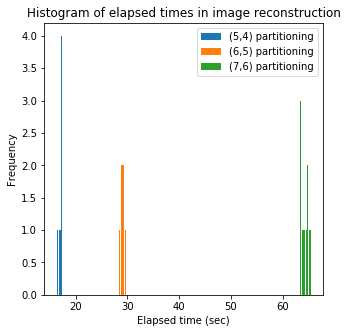

In [7]:
import matplotlib.pyplot as plt

## Plotting histogram of performance (elapsed time) data ##
print('NOTE: These data are for naive method ' + pathString + ' reconstruction.')

fig = plt.figure(figsize=(5,5))
plt.hist(etVec[0,:])
plt.hist(etVec[1,:])
plt.hist(etVec[2,:])
plt.xlabel("Elapsed time (sec)")
plt.ylabel("Frequency")
plt.title("Histogram of elapsed times in image reconstruction")
plt.legend(['({},{}) partitioning'.format(rowPartitions[0],colPartitions[0]),
               '({},{}) partitioning'.format(rowPartitions[1],colPartitions[1]),
                  '({},{}) partitioning'.format(rowPartitions[2],colPartitions[2])])
plt.show()

NOTE: These data are for naive method TestImages/kitty.jpg reconstruction.


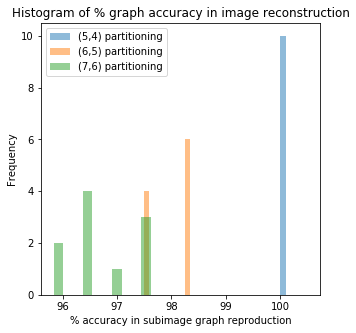

In [8]:
## Plotting histogram of performance (elapsed time) data ##
print('NOTE: These data are for naive method ' + pathString + ' reconstruction.')

fig = plt.figure(figsize=(5,5))
plt.hist(accuracyVec[0,:],alpha = 0.5)
plt.hist(accuracyVec[1,:],alpha = 0.5)
plt.hist(accuracyVec[2,:],alpha = 0.5)
plt.xlabel("% accuracy in subimage graph reproduction")
plt.ylabel("Frequency")
plt.title("Histogram of % graph accuracy in image reconstruction")
plt.legend(['({},{}) partitioning'.format(rowPartitions[0],colPartitions[0]),
               '({},{}) partitioning'.format(rowPartitions[1],colPartitions[1]),
                  '({},{}) partitioning'.format(rowPartitions[2],colPartitions[2])])
plt.show()

In [ ]:
# optional: viewing most recent shuffled and (below) reconstructed image data
#myRecon.imShuffled1

In [ ]:
#myRecon.imReconstructed